In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 불러오기 함수 정의
def load_data(battery):
    mat = loadmat('C:/LEE/batterydata/' + battery + '.mat')
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, date_time, voltage_measured,
                                current_measured, temperature_measured, time])
            counter += 1

    return pd.DataFrame(data=dataset,
                        columns=['cycle', 'datetime', 'voltage_measured',
                                 'current_measured', 'temperature_measured', 'time'])

In [3]:
# SOC 계산 함수 정의
def calculate_soc(initial_soc, current_data, time_intervals, battery_capacity):
    soc = [initial_soc]
    for i in range(1, len(current_data)):
        delta_time = (time_intervals[i] - time_intervals[i - 1]).total_seconds() / 3600  # 시간 간격 (시간 단위)
        soc_change = (current_data[i] * delta_time) / battery_capacity
        new_soc = soc[-1] - soc_change  # SOC 업데이트
        soc.append(max(0, min(1, new_soc)))  # SOC는 0에서 1 사이로 제한
    return soc

In [4]:
# 데이터 불러오기
dataset = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())

Total data in dataset:  616
   cycle            datetime  voltage_measured  current_measured  \
0      1 2008-04-02 15:25:41          4.191492         -0.004902   
1      1 2008-04-02 15:25:41          4.190749         -0.001478   
2      1 2008-04-02 15:25:41          3.974871         -2.012528   
3      1 2008-04-02 15:25:41          3.951717         -2.013979   
4      1 2008-04-02 15:25:41          3.934352         -2.011144   

   temperature_measured    time  
0             24.330034   0.000  
1             24.325993  16.781  
2             24.389085  35.703  
3             24.544752  53.781  
4             24.731385  71.922  


In [5]:
# 초기 SOC 설정 (보통 1.0으로 시작)
initial_soc = 1.0
battery_capacity = 2.0  # 배터리의 정격 용량 (예: 2Ah)

# 시간 차이를 계산하여 SOC 계산
dataset['SOC'] = calculate_soc(initial_soc, dataset['current_measured'], dataset['datetime'], battery_capacity)

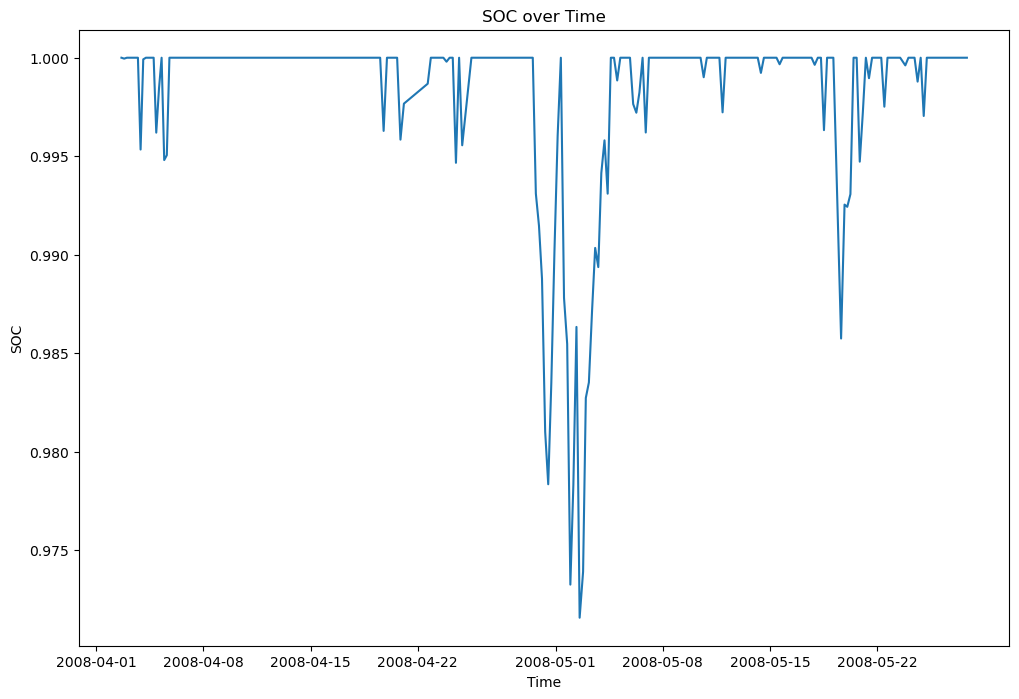

In [6]:
# 데이터 시각화 - SOC 그래프
plt.figure(figsize=(12, 8))
plt.plot(dataset['datetime'], dataset['SOC'])
plt.ylabel('SOC')
plt.xlabel('Time')
plt.title('SOC over Time')
plt.show()

In [7]:
# 데이터 준비 - 온도, 전류, 전압
attribs = ['voltage_measured', 'current_measured', 'temperature_measured']
train_data = dataset[attribs]

In [9]:
# 스케일링
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(train_data)

# LSTM 입력 데이터 생성 (25개 샘플의 시퀀스를 사용)
X = []
y = []
sequence_length = 25  # 25개 샘플을 사용

for i in range(sequence_length, len(train_data_scaled)):
    X.append(train_data_scaled[i-sequence_length:i, :])  # 온도, 전류, 전압 열을 입력으로 사용
    y.append(dataset['SOC'][i])  # SOC를 타겟으로 사용
X, y = np.array(X), np.array(y)

# 학습 데이터와 테스트 데이터 분할 (예: 80% 학습, 20% 테스트)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 모델 학습
model.fit(X_train, y_train, epochs=200, batch_size=5, validation_split=0.2, callbacks=[early_stopping])

# 모델 요약 출력
model.summary()

Epoch 1/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 178s 27ms/step - loss: 0.0096 - val_loss: 6.0194e-04
Epoch 2/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 131s 20ms/step - loss: 5.1961e-04 - val_loss: 1.2710e-05
Epoch 3/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - loss: 5.3236e-05 - val_loss: 2.2817e-05
Epoch 4/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 143s 22ms/step - loss: 4.9184e-05 - val_loss: 1.2700e-05
Epoch 5/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - loss: 4.8861e-05 - val_loss: 1.6906e-05
Epoch 6/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 144s 22ms/step - loss: 4.8810e-05 - val_loss: 3.9288e-05
Epoch 7/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 4.8342e-05 - val_loss: 1.4710e-05
Epoch 8/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 138s 22ms/step - loss: 4.8933e-05 - val_loss: 1.3750e-05
Epoch 9/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 142s 22ms/step - loss: 4.7129e-05 - val_loss: 1.4323e-05
Epoch 10/200
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 137s 21ms/step - loss: 4.9559e-05 - val_loss: 3.4360e-05
Epo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 25, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 25, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 607,505 (2.32 MB)

 Trainable params: 202,501 (791.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 405,004 (1.54 MB)

In [13]:
model.save('soc_lstm_sequence(25),140.keras')

In [11]:
# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 8.0977e-06
Test Loss: 6.353156550176209e-06


In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step
Test RMSE: 0.00252054736204659
